## Setup

In [1]:
import torch, random
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = (
    "cuda" if torch.cuda.is_available()
    else ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


## loading dataset and normalizing

In [3]:
# Loading CIFAR10 Dataset
root = "./data"
train_full = datasets.CIFAR10(root=root, train=True, download=True, transform=transforms.ToTensor())
test_full   = datasets.CIFAR10(root=root, train=False, download=True, transform=transforms.ToTensor())
print(f"Train/Test sizes: {len(train_full)}, {len(test_full)}")

100.0%


Train/Test sizes: 50000, 10000


In [4]:
# Compute mean and std of CIFAR10 training set because i was bored
loader = DataLoader(train_full, batch_size=1024, shuffle=False, num_workers=2)
n, mean, M2 = 0, torch.zeros(3), torch.zeros(3)  
for imgs, _ in loader:
    B = imgs.size(0)
    pixels = imgs.view(B, 3, -1)                 
    batch_mean = pixels.mean(dim=(0, 2))         
    batch_var  = pixels.var(dim=(0, 2), unbiased=False)
    n_new = n + B
    delta = batch_mean - mean
    mean += delta * (B / max(n_new, 1))
    M2   += batch_var * B + (delta**2) * (n * B / max(n_new, 1))
    n = n_new

computed_mean = mean
computed_std  = torch.sqrt(M2 / (n - 1))
CIFAR10_MEAN = tuple(float(x) for x in computed_mean)
CIFAR10_STD  = tuple(float(x) for x in computed_std)
print("computed_mean:", CIFAR10_MEAN)
print("computed_std :", CIFAR10_STD)

computed_mean: (0.4913996756076813, 0.4821583926677704, 0.44653087854385376)
computed_std : (0.2470347136259079, 0.24348759651184082, 0.26159045100212097)


In [5]:
# Normalize CIFAR-10 
normalize = transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD)
train_full.transform = transforms.Compose([transforms.ToTensor(), normalize])
test_full.transform  = transforms.Compose([transforms.ToTensor(), normalize])

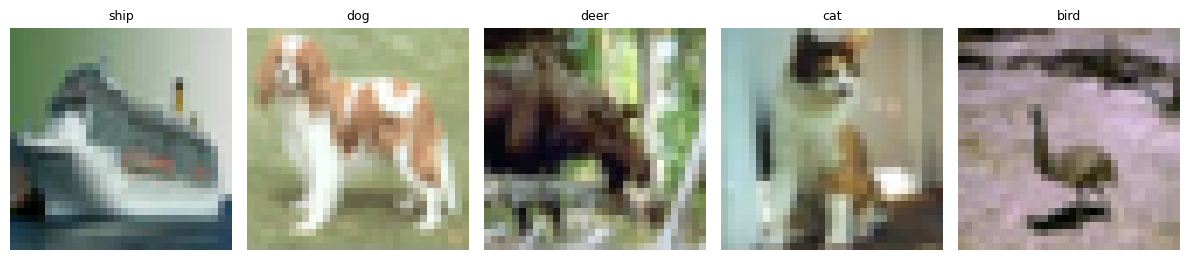

In [6]:
#Display 5 random images from the training set
def unnormalize(img):
    mean = torch.tensor(CIFAR10_MEAN).view(3,1,1)
    std  = torch.tensor(CIFAR10_STD).view(3,1,1)
    return (img * std + mean).clamp(0, 1)

classes = train_full.classes
idxs = random.sample(range(len(train_full)), 5)

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for ax, i in zip(axes, idxs):
    img, lbl = train_full[i]
    img = unnormalize(img)
    ax.imshow(img.permute(1,2,0).numpy())
    ax.set_title(classes[lbl], fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()

## CNN arch

In [7]:
#Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2) 
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)   
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Training loop

In [8]:
#split & load data
SEED = 42
g = torch.Generator().manual_seed(SEED)

n_total = len(train_full)        
train_size = int(0.80 * n_total)
val_size   = n_total - train_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=g)

BATCH_SIZE = 128
pin = torch.cuda.is_available()
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=pin)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin)
test_loader  = DataLoader(test_full, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin)

len(train_set), len(val_set), len(test_full)

(40000, 10000, 10000)

In [9]:
#fixing lossfunction and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
#def train and eval loss functions
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, total = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        bs = y.size(0)
        running_loss += loss.item() * bs
        total += bs
    return running_loss / total

@torch.no_grad()
def evaluate_loss(model, loader, criterion, device):
    model.eval()
    running_loss, total = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        bs = y.size(0)
        running_loss += loss.item() * bs
        total += bs
    return running_loss / total

In [11]:
#training loop 
EPOCHS = 5
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    tl = train_one_epoch(model, train_loader, optimizer, criterion, device)
    vl = evaluate_loss(model, val_loader, criterion, device)
    train_losses.append(tl); val_losses.append(vl)
    print(f"Epoch {epoch:02d} | train_loss={tl:.4f} | val_loss={vl:.4f}")


Epoch 00 | train_loss=1.3159 | val_loss=1.0954
Epoch 01 | train_loss=0.9627 | val_loss=0.9966
Epoch 02 | train_loss=0.8352 | val_loss=0.8987
Epoch 03 | train_loss=0.7634 | val_loss=0.8453
Epoch 04 | train_loss=0.6812 | val_loss=0.8289


## Train vs Val Loss plot

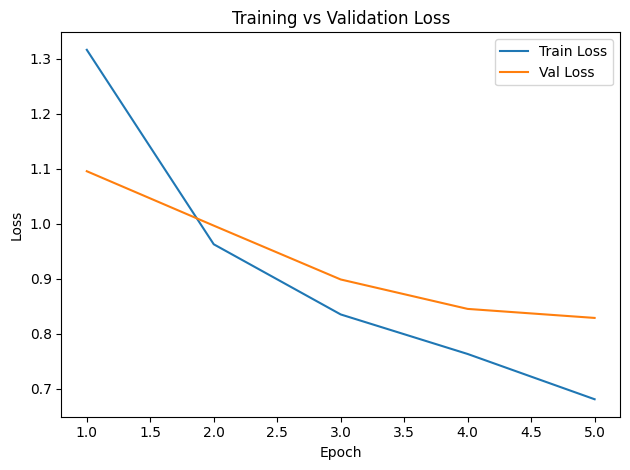

In [12]:
# Plot training vs validation loss curves
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1),   val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

## evaluation and display prediction

In [13]:
#Evaluate on test set 
@torch.no_grad()
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)                
        preds = logits.argmax(dim=1)      
        correct += (preds == y).sum().item()
        total   += y.size(0)
    return correct / total
test_acc = evaluate_accuracy(model, test_loader, device)
print(f"Test set accuracy: {test_acc*100:.2f}%")

Test set accuracy: 71.16%


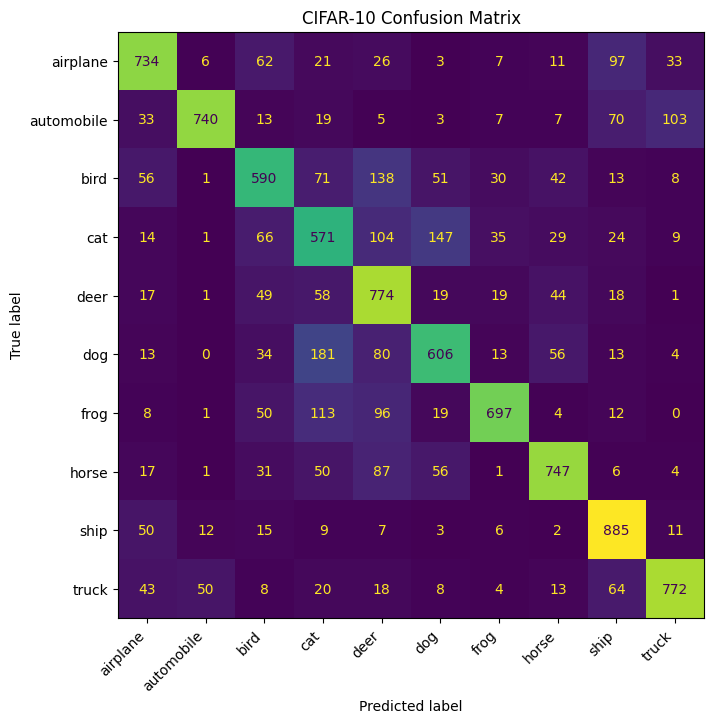

In [14]:
#confusion matrix
@torch.no_grad()
def collect_preds(model, loader, device):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(device)
        p = model(x).argmax(dim=1).cpu().numpy()
        all_p.append(p); all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = collect_preds(model, test_loader, device)
cm = confusion_matrix(y_true, y_pred)
labels = train_full.classes

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, values_format='d', cmap='viridis', colorbar=False)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("CIFAR-10 Confusion Matrix")
plt.tight_layout()
plt.subplots_adjust(bottom=0.22)   
plt.show()

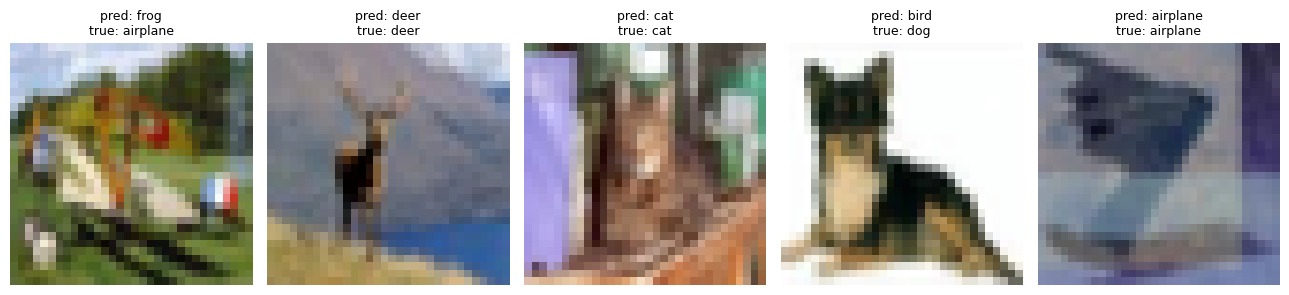

In [15]:
#Display 5 random predictions
idxs = random.sample(range(len(test_full)), 5)
model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(1, 5, figsize=(13,3))
    for ax, i in zip(axes, idxs):
        img, lbl = test_full[i]                 # normalized tensor
        logits = model(img.unsqueeze(0).to(device))
        pred = logits.argmax(dim=1).item()
        img_disp = unnormalize(img).permute(1,2,0).numpy()
        ax.imshow(img_disp, interpolation='nearest')
        ax.set_title(f"pred: {classes[pred]}\ntrue: {classes[lbl]}", fontsize=9)
        ax.axis("off")
    plt.tight_layout(); plt.savefig("sample_predictions.png", dpi=150); plt.show()

## Save Model

In [16]:
import torch, json, os
os.makedirs("deploy/weights", exist_ok=True)
os.makedirs("deploy/configs", exist_ok=True)

# adjust names if your variables differ
torch.save(model.state_dict(), "deploy/weights/model.pth")

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
with open("deploy/configs/classes.json","w") as f: json.dump(classes,f)

norm = {"mean":[0.4914,0.4822,0.4465],"std":[0.2470,0.2435,0.2616]}
with open("deploy/configs/norm.json","w") as f: json.dump(norm,f)